In [1]:
%run ../../bin/imports.ipynb

In [2]:
from sklearn import svm
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_score, cross_validate
from sklearn.linear_model import LogisticRegression, Lasso
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, roc_auc_score, f1_score
from statistics import mean
from sklearn import metrics

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
green = '#77c722'
blue = '#3864b5'
orange = '#E1812C'
red = '#BE1D2C'


## Training the model

In [5]:
# Need to get this on the same scale, regardless of which is lower
def get_lower_value(x):
    if math.isnan(x[0]):
        return 0.5
    elif x[0] < x[1]:
        return 0
    else:
        return 1

def get_new_features(df):
    for i in range(0, 24):
        df['minCoverage_'+str(i)] = np.min(df[['coverage1_'+str(i), 'coverage2_'+str(i)]], axis=1)
        #df['medCoverage1'+str(i)] = df[['coverage1_'+str(i)]]
        df['a1lowerCov_'+str(i)] = df[['coverage1_'+str(i), 'coverage2_'+str(i)]].apply(get_lower_value, axis=1)
        df['a2lowerCov_'+str(i)] = df[['coverage2_'+str(i), 'coverage1_'+str(i)]].apply(get_lower_value, axis=1)
        df['sumCoverage_'+str(i)] = df[['coverage1_'+str(i), 'coverage2_'+str(i)]].sum(axis=1)
    df['baf_median'] = abs(df[[x for x in list(df.columns) if 'baf_' in x]].median(axis=1))
    df['baf_sum'] = df[[x for x in list(df.columns) if 'baf_' in x]].sum(axis=1)
    df['baf_sum_abs'] = abs(df['baf_sum'])
    
    df['totalCoverage_median'] = df[[x for x in list(df.columns) if 'sumCoverage_' in x]].median(axis=1)
    df['minCoverage_median'] = df[[x for x in list(df.columns) if 'minCoverage_' in x]].median(axis=1)
    df['medCoverage1'] = df[[x for x in list(df.columns) if 'coverage1_' in x]].median(axis=1)
    df['medCoverage2'] = df[[x for x in list(df.columns) if 'coverage2_' in x]].median(axis=1)
    #df['minMedCoverage'] = df[['medCoverage1', 'medCoverage2']].apply(get_lower_value, axis=1)
    df['minMedCoverage'] = df[['medCoverage1', 'medCoverage2']].min(axis=1)
    df['a1PercCov'] = df[[x for x in list(df.columns) if 'a1lowerCov_' in x]].mean(axis=1)
    df['a2PercCov'] = df[[x for x in list(df.columns) if 'a2lowerCov_' in x]].mean(axis=1)
    df['percCov'] = df[['a1PercCov', 'a2PercCov']].max(axis=1)
    df['Sequenza_Loss'] = ~df.sequenza_minor.astype(bool)
    df['Sequenza_imbalance'] = df['sequenza_major'] != df['sequenza_minor']
    df['Sequenza_difference'] = df['sequenza_major'] - df['sequenza_minor']
    return df

#### Import the training data

In [6]:
overall_df = pd.read_csv('/rnd/users/rpyke/data/00-DASH/manuscript_data_v2/training.all_data.csv')
overall_df = get_new_features(overall_df)

In [7]:
overall_df.head()

sample gene  purity  ploidy  sequenza_major  sequenza_minor  \
0  DNA_S000443705    A    0.64       2             2.0             2.0   
1  DNA_S000443705    B    0.64       2             2.0             1.0   
2  DNA_S000443705    C    0.64       2             2.0             2.0   
3      DNA_302298    A    0.35       2             1.0             1.0   
4      DNA_302298    C    0.35       2             1.0             1.0   

      baf_0     baf_1     baf_2     baf_3  ...  minCoverage_median  \
0       NaN       NaN -0.026054 -0.035957  ...            0.703974   
1       NaN       NaN -0.024833  0.002578  ...            0.564464   
2  0.046311  0.032911 -0.014469 -0.029771  ...            0.650248   
3 -0.011801  0.011353  0.059889  0.058102  ...            0.970497   
4 -0.024988 -0.025108 -0.029734 -0.065980  ...            1.034362   

   medCoverage1  medCoverage2  minMedCoverage  a1PercCov  a2PercCov   percCov  \
0      0.711237      0.878719        0.711237   0.270833   0.729167  0.729167   
1      0.671202      0.634174        0.634174   0.500000   0.500000  0.500000   
2      0.767484      0.842796        0.767484   0.437500   0.562500  0.562500   
3      1.025303      0.983976        0.983976   0.583333   0.416667  0.583333   
4      1.089240      1.143182        1.089240   0.375000   0.625000  0.625000   

   Sequenza_Loss  Sequenza_imbalance  Sequenza_difference  
0          False               False                  0.0  
1          False                True                  1.0  
2          False               False                  0.0  
3          False               False                  0.0  
4          False               False                  0.0  

[5 rows x 217 columns]

Get the assignments from the full model (potentially no longer needed because of CV?)

In [8]:
dash_output_df = pd.read_csv('/rnd/users/rpyke/data/00-DASH/manuscript_data_v2/pancancer.dash_output.csv', index_col=0)
print(len(dash_output_df['Sample'].unique()))

609


In [9]:
dash_output_df.head()

hla_locus  hla_locus_cntr        dash_allele hla_assign_allele  purity  \
0         A               1     hla_a_11_01_01        A*11:01:01    0.59   
1         A               2  hla_a_02_01_01_01     A*02:01:01:01    0.59   
2         B               1     hla_b_07_02_01        B*07:02:01    0.59   
3         B               2  hla_b_44_02_01_01     B*44:02:01:01    0.59   
4         C               1     hla_c_07_04_01        C*07:04:01    0.59   

   ploidy alternate_copy_number alternate_allelic_imbalance  \
0       2     0.954528661480121          0.1396995991856002   
1       2    1.1057150882186553          0.1396995991856002   
2       2    1.2609575305311944        5.46589459102549e-09   
3       2      0.92425847923387        5.46589459102549e-09   
4       2     1.217143898726644       0.0014113193379766864   

   alternate_deletion              dash_r          dash_adj_baf  \
0               False  1.0101327646302274  0.013659546387627177   
1               False   0.978562589275474  0.013659546387627177   
2               False  1.1222587728426323  0.024985149802174426   
3               False  1.0166830101556927  0.024985149802174426   
4               False  1.1476173426890357  0.010062652916660196   

   raw_dash_deletion  dash_deletion  sequenza_majors  sequenza_minors  \
0              False          False              1.0              1.0   
1              False          False              1.0              1.0   
2              False          False              1.0              1.0   
3              False          False              1.0              1.0   
4              False          False              1.0              1.0   

   consistency_of_coverage  total_coverage  prediction_probability  \
0                 0.562500        1.958065                0.001676   
1                 0.562500        1.958065                0.001676   
2                 0.586957        2.153896                0.001239   
3                 0.586957        2.153896                0.001239   
4                 0.608696        2.376238                0.001102   

   secondary_check          Sample  
0             True  DNA_S000460823  
1             True  DNA_S000460823  
2             True  DNA_S000460823  
3             True  DNA_S000460823  
4             True  DNA_S000460823

In [10]:
dash_output_df['sample'] = dash_output_df['Sample']
dash_output_df['Prediction'] = dash_output_df['dash_deletion']
dash_output_df['gene'] = dash_output_df['hla_locus']
dash_output_df = dash_output_df.sort_values('dash_deletion', ascending=False)
dash_output_df = dash_output_df[['sample', 'gene', 'raw_dash_deletion', 'secondary_check',
                                 'Prediction', 'prediction_probability']].drop_duplicates(['sample', 'gene'])

In [11]:
len(dash_output_df)

1826

In [12]:
# Merge in the secondary check here... 
overall_df = pd.merge(overall_df, dash_output_df[['sample', 'gene', 'secondary_check']], 
                             on=['sample', 'gene'], how='left')

#### Performance with naive LOH caller

In [13]:
##### Accuracy with just Sequenza ####
print('F1: ', sklearn.metrics.f1_score(overall_df.Sequenza_Loss, overall_df.LOH))
print('Accuracy: ', sklearn.metrics.accuracy_score(overall_df.Sequenza_Loss, overall_df.LOH))

F1:  0.8481012658227848
Accuracy:  0.9333333333333333


In [14]:
print('Sensitivity', 
      len(overall_df[(overall_df.LOH == True)&(overall_df.Sequenza_Loss == True)]) / len(overall_df[(overall_df.LOH == True) & (overall_df.Sequenza_Loss.notna())]))
print('Specificity', 
      len(overall_df[(overall_df.LOH == False)&(overall_df.Sequenza_Loss == False)]) / len(overall_df[(overall_df.LOH == False) & (overall_df.Sequenza_Loss.notna())]))


Sensitivity 0.950354609929078
Specificity 0.9291882556131261


In [15]:
##### Accuracy with just Sequenza - high purity ####
print('F1: ', sklearn.metrics.f1_score(overall_df[overall_df.purity > 0.2].Sequenza_Loss, 
                                       overall_df[overall_df.purity > 0.2].LOH))
print('Accuracy: ', sklearn.metrics.accuracy_score(overall_df[overall_df.purity > 0.2].Sequenza_Loss, 
                                                   overall_df[overall_df.purity > 0.2].LOH))

F1:  0.9275362318840579
Accuracy:  0.9694501018329938


##### Performance with LOHHLA

In [16]:
lohhla_df = pd.read_csv('/rnd/users/rpyke/data/00-DASH/manuscript_data_v2/pancancer.lohhla_output.csv', index_col=0)
lohhla_df['sample'] = lohhla_df['region']
lohhla_df['gene'] = lohhla_df['HLA_A_type1'].str.split('hla_').str[1].str.split('_').str[0].str.upper()
lohhla_df['LOHHLA'] = lohhla_df['LOH']

In [17]:
len(lohhla_df)

1439

In [18]:
lohhla_df.head()

region        HLA_A_type1        HLA_A_type2  \
0  DNA_ILS50527PT6     hla_a_11_01_01     hla_a_33_03_01   
2  DNA_ILS50527PT6        hla_b_15_35     hla_b_58_01_01   
5  DNA_ILS50527PT6  hla_c_03_02_02_01  hla_c_07_02_01_01   
0  DNA_ILS51039PT2  hla_a_01_01_01_01     hla_a_02_06_01   
2  DNA_ILS51039PT2  hla_b_35_01_01_01     hla_b_55_02_01   

   HLA_type1copyNum_withBAFBin  HLA_type2copyNum_withBAFBin   PVal_unique  \
0                     4.750606                     0.031963  3.913078e-51   
2                     4.844561                     0.042261  1.321898e-33   
5                     0.159054                     4.804306  8.435445e-64   
0                     2.376083                     0.922969  3.959785e-09   
2                     1.125873                     2.465880  5.279493e-04   

          LossAllele         KeptAllele         LOH_allele    LOH  \
0     hla_a_33_03_01     hla_a_11_01_01     hla_a_33_03_01   True   
2     hla_b_58_01_01        hla_b_15_35     hla_b_58_01_01   True   
5  hla_c_03_02_02_01  hla_c_07_02_01_01  hla_c_03_02_02_01   True   
0     hla_a_02_06_01  hla_a_01_01_01_01                NaN  False   
2  hla_b_35_01_01_01     hla_b_55_02_01                NaN  False   

            sample gene  LOHHLA  
0  DNA_ILS50527PT6    A    True  
2  DNA_ILS50527PT6    B    True  
5  DNA_ILS50527PT6    C    True  
0  DNA_ILS51039PT2    A   False  
2  DNA_ILS51039PT2    B   False

In [19]:
overall_df_lohhla = pd.merge(overall_df, lohhla_df[['sample', 'gene', 'LOHHLA']], 
                          on=['sample', 'gene'], how='left')
overall_df_lohhla = overall_df_lohhla.dropna(subset=['LOHHLA'])
overall_df_lohhla['LOHHLA'] = overall_df_lohhla.LOHHLA.astype(bool)

In [20]:
len(overall_df_lohhla)

715

In [24]:
overall_df_lohhla[['LOHHLA', 'LOH']].dtypes

LOHHLA    bool
LOH       bool
dtype: object

In [25]:
print('F1: ', sklearn.metrics.f1_score(overall_df_lohhla.LOHHLA, overall_df_lohhla.LOH))
print('Accuracy: ', sklearn.metrics.accuracy_score(overall_df_lohhla.LOHHLA, overall_df_lohhla.LOH))

F1:  0.776978417266187
Accuracy:  0.9132867132867133


In [26]:
print('Sensitivity', 
      len(overall_df_lohhla[(overall_df_lohhla.LOH == True)&(overall_df_lohhla.LOHHLA == True)]) / len(overall_df_lohhla[(overall_df_lohhla.LOH == True) & (overall_df_lohhla.LOHHLA.notna())]))
print('Specificity', 
      len(overall_df_lohhla[(overall_df_lohhla.LOH == False)&(overall_df_lohhla.LOHHLA == False)]) / len(overall_df_lohhla[(overall_df_lohhla.LOH == False) & (overall_df_lohhla.LOHHLA.notna())]))


Sensitivity 0.7883211678832117
Specificity 0.9429065743944637


In [27]:
print('F1: ', sklearn.metrics.f1_score(overall_df_lohhla[overall_df_lohhla.purity > 0.2].LOHHLA, 
                                       overall_df_lohhla[overall_df_lohhla.purity > 0.2].LOH))
print('Accuracy: ', sklearn.metrics.accuracy_score(overall_df_lohhla[overall_df_lohhla.purity > 0.2].LOHHLA, 
                                                   overall_df_lohhla[overall_df_lohhla.purity > 0.2].LOH))

F1:  0.8571428571428571
Accuracy:  0.9382716049382716


#### Comparison of multiple algorithms

In [28]:
# Function to split, train & test kfolds data with threshold of 0.2
def cross_validate_model(model, X, y, threshold, verbose):
    
    score_dict = {}
    
    f1_scores = []
    accuracy_scores = []
    sensitivity_scores = []
    specificity_scores = []
    all_tmp_results = []

    # split data
    for train_index, test_index in folds.split(X, y):
        X_train, X_test, y_train, y_test = X.iloc[train_index], X.iloc[test_index], y.iloc[train_index], y.iloc[test_index]
        if model == svm.SVC:
            mla = model(probability=True).fit(X=X_train, y=y_train)
        else:
            mla = model().fit(X=X_train, y=y_train)
        preds = np.where(mla.predict_proba(X_test)[:,1] > threshold, 1, 0)
        pred_probs = mla.predict_proba(X_test)[:,1]
        
        tmp_results_df = pd.DataFrame({'Index': test_index, 'raw_DASH_prediction': preds,
                                      'raw_DASH_probability': pred_probs})

        f1 = f1_score(y_test, preds)
        f1_scores.append(f1)

        accuracy = accuracy_score(y_test, preds)
        accuracy_scores.append(accuracy)

        sensitivity = recall_score(y_test, preds)
        sensitivity_scores.append(sensitivity)

        specificity = recall_score(y_test, preds, pos_label = 0)
        specificity_scores.append(specificity)
    #     scores_logistic.append(get_score(LogisticRegression(solver='liblinear',multi_class='ovr'), X_train, X_test, y_train, y_test))

        all_tmp_results.append(tmp_results_df)
    
    results_df = pd.concat(all_tmp_results)
    
    # scores_logistic
    if verbose:
        print('-----F1-----')
        print(f1_scores)
        print(F"\nAvg F1: {mean(f1_scores)}")
        print()
        print('-----Accuracy-----')
        print(accuracy_scores)
        print(F"\nAvg Accuracy: {mean(accuracy_scores)}")
        print()
        print('-----Sensitivity-----')
        print(sensitivity_scores)
        print(F"\nAvg Sensitivity: {mean(sensitivity_scores)}")
        print()
        print('-----Specificity-----')
        print(specificity_scores)
        print(F"\nAvg Specificity: {mean(specificity_scores)}")
        print()
    
    score_dict['F1'] = f1_scores
    score_dict['Accuracy'] = accuracy_scores
    score_dict['Sensitivity'] = sensitivity_scores
    score_dict['Specificity'] = specificity_scores
    
    return score_dict, results_df
    

In [29]:
training_columns = ['purity', 'ploidy', 'sequenza_minor',
                    'minMedCoverage','baf_median', 'percCov', 'totalCoverage_median']

In [30]:
# Logistic Regression
X = overall_df[training_columns]
y = overall_df[['LOH']]

print(len(X))
print(len(y))

def get_score(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    return model.score(X_test, y_test)

folds = StratifiedKFold(n_splits=10)

720
720


In [31]:
threshold = 0.5

# LR
model = LogisticRegression
logisitic_scores, LR_results_df = cross_validate_model(model, X, y, threshold, False)

# KNN
model = KNeighborsClassifier
knn_scores, knn_results_df = cross_validate_model(model, X, y, threshold, False)

# SVM
model = svm.SVC
svc_scores, svc_results_df = cross_validate_model(model, X, y, threshold, False)

# XGBoost
model = XGBClassifier
xgboost_scores, xgb_results_df = cross_validate_model(model, X, y, threshold, False)

In [32]:
mla_list = ['Logistic regression', 'XGBoost', 'SVM', 'KNN']
mla_score_list = [logisitic_scores, xgboost_scores, svc_scores, knn_scores]
mla_dict = {}
for mla, score in zip(mla_list, mla_score_list):
    mla_dict[mla] = {"F1": score['F1'], "Sensitivity": score['Sensitivity'], "Specificity": score['Specificity']}
    

for mla in mla_dict:
    print(F"----- {mla} -----")
    print(F"F1: {mean(mla_dict[mla]['F1'])}")
    print(F"Sensitivity: {mean(mla_dict[mla]['Sensitivity'])}")
    print(F"Specificity: {mean(mla_dict[mla]['Specificity'])}\n")
    


# create a df of scores
mean_df = pd.DataFrame()
mean_mlas = []
mean_f1s = []
mean_sensitivities = []
mean_specificities = []

dataframe_list = []
for scores, mla in zip(mla_score_list, mla_list):
    score_df = pd.DataFrame()
    score_df['F1'] = scores['F1']
    score_df['Sensitivity'] = scores['Sensitivity']
    score_df['Specificity'] = scores['Specificity']
    score_df['Algorithm'] = mla
    dataframe_list.append(score_df)
    
    mean_f1 = mean(score_df['F1'])
    mean_sensitivity = mean(score_df['Sensitivity'])
    mean_specificity = mean(score_df['Specificity'])
    
    mean_mlas.append(mla)
    mean_f1s.append(mean_f1)
    mean_sensitivities.append(mean_sensitivity)
    mean_specificities.append(mean_specificity)
    
    
mean_df['Algorithm'] = mean_mlas
mean_df['F1'] = mean_f1s
mean_df['Sensitivity'] = mean_sensitivities
mean_df['Specificity'] = mean_specificities
    
combined_df = pd.concat(dataframe_list)

----- Logistic regression -----
F1: 0.9060490435490436
Sensitivity: 0.8861904761904762
Specificity: 0.9844827586206897

----- XGBoost -----
F1: 0.9390731618317826
Sensitivity: 0.929047619047619
Specificity: 0.9879310344827587

----- SVM -----
F1: 0.901192756796205
Sensitivity: 0.9004761904761904
Specificity: 0.9758620689655173

----- KNN -----
F1: 0.8850539977264115
Sensitivity: 0.871904761904762
Specificity: 0.9775862068965517



In [33]:
# Shorten the names
mean_df = mean_df.replace('Logistic regression', 'LR')
mean_df = mean_df.replace('XGBoost', 'XGB')

combined_df = combined_df.replace('Logistic regression', 'LR')
combined_df = combined_df.replace('XGBoost', 'XGB')

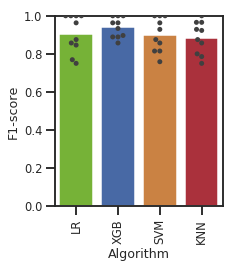

In [34]:
# plot F1 scores
sns.set_context('talk', font_scale=0.7)
sns.set_style("ticks")
plt.figure(figsize=(3, 3.5))

f1_barplot = sns.barplot(x='Algorithm', y='F1', data=mean_df, palette=[green, blue, orange, red])
f1_barplot = sns.swarmplot(x="Algorithm", y="F1", data=combined_df, color=".25")
f1_barplot.set_xticklabels(f1_barplot.get_xticklabels(), rotation=90)
f1_barplot.set(ylim=(0, 1))

plt.ylabel('F1-score')

# plt.title("K-folds cross validation")
plt.savefig('/rnd/users/rpyke/data/00-DASH/figures/training.comparison_of_algorithms.pdf',
           bbox_inches='tight')

In [35]:
# Saving source data
panel_name = 'supp_figure_3b'
combined_df[['Algorithm', 'F1']].to_excel('/rnd/users/rpyke/data/00-DASH/manuscript_source_data/{0}.xlsx'.format(panel_name),
                                 index=None)

#### Comparing performance of DASH with LOHHLA and Sequenza

In [36]:
# The specific calls for each patient with the CV for DASH
xgb_results_df.index = xgb_results_df.Index
overall_df = pd.merge(overall_df, xgb_results_df[['raw_DASH_prediction', 'raw_DASH_probability']],
                      right_index=True, left_index=True)

In [37]:
updated_prediction_probabilities = []
for raw, check, prob in zip(list(overall_df.raw_DASH_prediction), list(overall_df.secondary_check), 
                            list(overall_df.raw_DASH_probability
                                )):
    if (raw == True) and (check == True):
        updated_prediction_probabilities.append(0)
    else:
        updated_prediction_probabilities.append(prob)

overall_df['DASH_probability'] = updated_prediction_probabilities
overall_df['DASH_prediction'] = overall_df.raw_DASH_probability >= 0.5

In [38]:
overall_df = pd.merge(overall_df, lohhla_df[['sample', 'gene', 'LOHHLA']], 
                          on=['sample', 'gene'], how='left')

overall_df_hp = overall_df[overall_df.purity > 0.2]

In [39]:
results_df = pd.DataFrame({'Score': ['Sensitvity', 'Specificity', 'Sensitvity', 'Specificity'] + ['Sensitvity', 'Specificity', 'Sensitvity', 'Specificity'] + ['Sensitvity', 'Specificity', 'Sensitvity', 'Specificity'],
             'Algorithm': ['DASH (ImmunoID NeXT)', 'DASH (ImmunoID NeXT)', 'DASH (ImmunoID NeXT)', 'DASH (ImmunoID NeXT)'] + ['LOHHLA (ImmunoID NeXT)', 'LOHHLA (ImmunoID NeXT)', 'LOHHLA (ImmunoID NeXT)', 'LOHHLA (ImmunoID NeXT)'] + ['Sequenza (ImmunoID NeXT)', 'Sequenza (ImmunoID NeXT)', 'Sequenza (ImmunoID NeXT)', 'Sequenza (ImmunoID NeXT)'],
              'Purity_restriction': ['None', 'None', 'High', 'High'] + ['None', 'None', 'High', 'High'] + ['None', 'None', 'High', 'High'],
             'Value': [len(overall_df[(overall_df.LOH == True)&(overall_df.DASH_prediction == True)]) / len(overall_df[(overall_df.LOH == True) & (overall_df.DASH_prediction.notna())]),
                       len(overall_df[(overall_df.LOH == False)&(overall_df.DASH_prediction == False)]) / len(overall_df[(overall_df.LOH == False) & (overall_df.DASH_prediction.notna())]),
                      len(overall_df_hp[(overall_df_hp.LOH == True)&(overall_df_hp.DASH_prediction == True)]) / len(overall_df_hp[(overall_df_hp.LOH == True) & (overall_df_hp.DASH_prediction.notna())]),
                      len(overall_df_hp[(overall_df_hp.LOH == False)&(overall_df_hp.DASH_prediction == False)]) / len(overall_df_hp[(overall_df_hp.LOH == False) & (overall_df_hp.DASH_prediction.notna())]),
                      
                      # the divisor needs to be just samples in which LOHHLA predicted
                       len(overall_df[(overall_df.LOH == True)&(overall_df.LOHHLA == True)]) / len(overall_df[(overall_df.LOH == True) & (overall_df.LOHHLA.notna())]),
                       len(overall_df[(overall_df.LOH == False)&(overall_df.LOHHLA == False)]) / len(overall_df[(overall_df.LOH == False) & (overall_df.LOHHLA.notna())]),
                      len(overall_df_hp[(overall_df_hp.LOH == True)&(overall_df_hp.LOHHLA == True)]) / len(overall_df_hp[(overall_df_hp.LOH == True) & (overall_df_hp.LOHHLA.notna())]),
                      len(overall_df_hp[(overall_df_hp.LOH == False)&(overall_df_hp.LOHHLA == False)]) / len(overall_df_hp[(overall_df_hp.LOH == False) & (overall_df_hp.LOHHLA.notna())]),
                       
                      len(overall_df[(overall_df.LOH == True)&(overall_df.Sequenza_Loss == True)]) / len(overall_df[(overall_df.LOH == True) & (overall_df.Sequenza_Loss.notna())]),
                       len(overall_df[(overall_df.LOH == False)&(overall_df.Sequenza_Loss == False)]) / len(overall_df[(overall_df.LOH == False) & (overall_df.Sequenza_Loss.notna())]),
                      len(overall_df_hp[(overall_df_hp.LOH == True)&(overall_df_hp.Sequenza_Loss == True)]) / len(overall_df_hp[(overall_df_hp.LOH == True) & (overall_df_hp.Sequenza_Loss.notna())]),
                      len(overall_df_hp[(overall_df_hp.LOH == False)&(overall_df_hp.Sequenza_Loss == False)]) / len(overall_df_hp[(overall_df_hp.LOH == False) & (overall_df_hp.Sequenza_Loss.notna())])]})
            

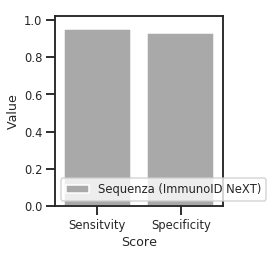

In [40]:
plt.figure(figsize=(3, 3.5))
sns.barplot(x='Score', y='Value', hue='Algorithm', 
            data=results_df[results_df.Purity_restriction == 'None'],
               palette=['darkgrey'], hue_order=['Sequenza (ImmunoID NeXT)'])
plt.legend(loc=3)
plt.ylim(0, 1.02)
plt.savefig('/rnd/users/rpyke/data/00-DASH/figures/sensitivity_specificity.cv_all_data.Sequenza.pdf',
           bbox_inches='tight')

In [41]:
green = '#77c722'
blue = '#3864b5'

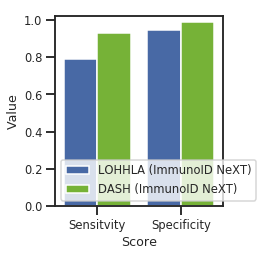

In [42]:
plt.figure(figsize=(3, 3.5))
sns.barplot(x='Score', y='Value', hue='Algorithm', 
            data=results_df[results_df.Purity_restriction == 'None'],
           #palette=[red, blue, green], 
            #hue_order=['LOHHLA (ImmunoID NeXT)', 'Sequenza (ImmunoID NeXT)', 'DASH (ImmunoID NeXT)'],
           palette=[blue, green], 
            hue_order=['LOHHLA (ImmunoID NeXT)', 'DASH (ImmunoID NeXT)'])
plt.legend(loc=3)
plt.ylim(0, 1.02)
plt.savefig('/rnd/users/rpyke/data/00-DASH/figures/sensitivity_specificity.cv_all_data.pdf',
           bbox_inches='tight')

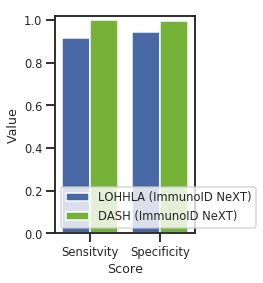

In [43]:
plt.figure(figsize=(2.5, 4))
sns.barplot(x='Score', y='Value', hue='Algorithm', 
            data=results_df[results_df.Purity_restriction == 'High'],
           palette=[blue, green], 
            hue_order=['LOHHLA (ImmunoID NeXT)', 'DASH (ImmunoID NeXT)'])
plt.legend(loc=3)
plt.ylim(0, 1.02)
plt.savefig('/rnd/users/rpyke/data/00-DASH/figures/sensitivity_specificity.cv_all_data.high_purity.pdf',
           bbox_inches='tight')

### F1-Score

F1 score (all samples) - DASH

In [44]:
precision = len(overall_df[(overall_df.LOH == True)&(overall_df.DASH_prediction == True)]) / len(overall_df[overall_df.DASH_prediction == True])
recall = len(overall_df[(overall_df.LOH == True)&(overall_df.DASH_prediction == True)]) / len(overall_df[overall_df.LOH == True])
print(precision, recall)
print('F1', 2*((precision*recall)/(precision+recall)))

0.9492753623188406 0.9290780141843972
F1 0.9390681003584229


F1 score (>20% tumor purity) - DASH

In [45]:
precision = len(overall_df_hp[(overall_df_hp.LOH == True)&(overall_df_hp.DASH_prediction == True)]) / len(overall_df_hp[overall_df_hp.DASH_prediction == True])
recall = len(overall_df_hp[(overall_df_hp.LOH == True)&(overall_df_hp.DASH_prediction == True)]) / len(overall_df_hp[overall_df_hp.LOH == True])
print(precision, recall)
print('F1', 2*((precision*recall)/(precision+recall)))

0.9902912621359223 1.0
F1 0.9951219512195122


F1 score (all samples) - LOHHLA

In [46]:
len(overall_df), len(overall_df[['LOH', 'LOHHLA']].dropna())

(720, 715)

In [47]:
overall_df_lohhla = overall_df[['LOH', 'LOHHLA']].dropna()

In [48]:
precision = len(overall_df_lohhla[(overall_df_lohhla.LOH == True)&(overall_df_lohhla.LOHHLA == True)]) / len(overall_df_lohhla[overall_df.LOHHLA == True])
recall = len(overall_df_lohhla[(overall_df_lohhla.LOH == True)&(overall_df_lohhla.LOHHLA == True)]) / len(overall_df_lohhla[overall_df_lohhla.LOH == True])
print(precision, recall)
print('F1', 2*((precision*recall)/(precision+recall)))

0.7659574468085106 0.7883211678832117
F1 0.776978417266187


F1 score (>20% tumor purity) - LOHHLA

In [49]:
overall_df_hp_lohhla = overall_df_hp[['LOH', 'LOHHLA']].dropna()

In [50]:
precision = len(overall_df_hp_lohhla[(overall_df_hp_lohhla.LOH == True)&(overall_df_hp_lohhla.LOHHLA == True)]) / len(overall_df_hp_lohhla[overall_df_hp_lohhla.LOHHLA == True])
recall = len(overall_df_hp_lohhla[(overall_df_hp_lohhla.LOH == True)&(overall_df_hp_lohhla.LOHHLA == True)]) / len(overall_df_hp_lohhla[overall_df_hp_lohhla.LOH == True])
print(precision, recall)
print('F1', 2*((precision*recall)/(precision+recall)))

0.8035714285714286 0.9183673469387755
F1 0.8571428571428571


F1 score (all samples) - Sequenza

In [51]:
precision = len(overall_df[(overall_df.LOH == True)&(overall_df.Sequenza_Loss == True)]) / len(overall_df[overall_df.Sequenza_Loss == True])
recall = len(overall_df[(overall_df.LOH == True)&(overall_df.Sequenza_Loss == True)]) / len(overall_df[overall_df.LOH == True])
print(precision, recall)
print('F1', 2*((precision*recall)/(precision+recall)))

0.7657142857142857 0.950354609929078
F1 0.8481012658227848


F1 score (>20% tumor purity) - Sequenza

In [52]:
precision = len(overall_df_hp[(overall_df_hp.LOH == True)&(overall_df_hp.Sequenza_Loss == True)]) / len(overall_df_hp[overall_df_hp.Sequenza_Loss == True])
recall = len(overall_df_hp[(overall_df_hp.LOH == True)&(overall_df_hp.Sequenza_Loss == True)]) / len(overall_df_hp[overall_df_hp.LOH == True])
print(precision, recall)
print('F1', 2*((precision*recall)/(precision+recall)))

0.9142857142857143 0.9411764705882353
F1 0.9275362318840579


Precision-Recall curve

In [53]:
dash_precision, dash_recall, dash_threshold = metrics.precision_recall_curve(overall_df['LOH'], 
                                                                    overall_df['DASH_probability'])

auprc = metrics.auc(dash_recall, dash_precision)
print('AUPRC: %.3f' % auprc)


dash_precision_hp, dash_recall_hp, dash_threshold_hp = metrics.precision_recall_curve(overall_df_hp['LOH'], 
                                                                    overall_df_hp['DASH_probability'])

auprc = metrics.auc(dash_recall_hp, dash_precision_hp)
print('AUPRC: %.3f' % auprc)


AUPRC: 0.940
AUPRC: 0.992


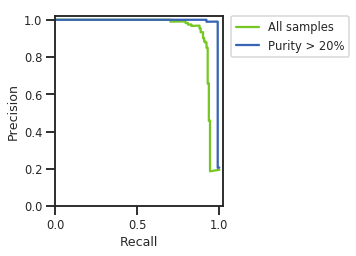

In [54]:
import seaborn as sns
import numpy as np

sns.set_context('talk', font_scale=0.7)
sns.set_style("ticks")
plt.figure(figsize=(3, 3.5))

plt.plot(dash_recall, dash_precision, color=green, label='All samples')
plt.plot(dash_recall_hp, dash_precision_hp, color=blue, label='Purity > 20%')


plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.ylim([0,1.02])
plt.xlim([0,1.02])

#plt.title("DASH PRC")
plt.savefig('/rnd/users/rpyke/data/00-DASH/figures/precision_recall.cv_all_data.pdf',
           bbox_inches='tight')

plt.show()

### AUROC

In [55]:
fpr, tpr, thresholds = metrics.roc_curve(overall_df['LOH'], 
                                         overall_df['DASH_probability'])
# print(fpr, tpr)

auc = metrics.roc_auc_score(overall_df['LOH'], 
                            overall_df['DASH_probability'])
print('AUROC: %.3f' % auc)

fpr_hp, tpr_hp, thresholds_hp = metrics.roc_curve(overall_df_hp['LOH'], 
                                                overall_df_hp['DASH_probability'])
# print(fpr, tpr)

auc = metrics.roc_auc_score(overall_df_hp['LOH'], 
                                overall_df_hp['DASH_probability'])
print('AUROC: %.3f' % auc)

AUROC: 0.939
AUROC: 0.990


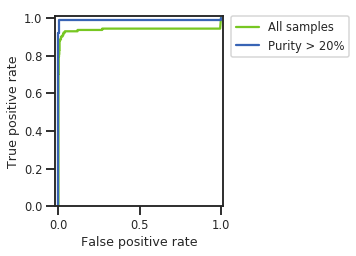

In [56]:
sns.set_context('talk', font_scale=0.7)
sns.set_style("ticks")

plt.figure(figsize=(3, 3.5))

plt.plot(fpr, tpr, color=green, label='All samples')
plt.plot(fpr_hp, tpr_hp, color=blue, label='Purity > 20%')


plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlim([-0.02,1.01])
plt.ylim([0,1.01])

#plt.title("DASH ROC")
plt.savefig('/rnd/users/rpyke/data/00-DASH/figures/ROC.cv_all_data.pdf',
           bbox_inches='tight')
plt.show()

##### Miscalls

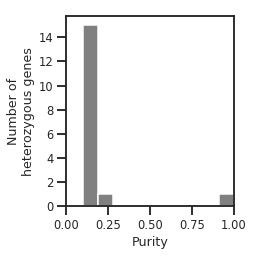

In [57]:
plt.figure(figsize=(3, 3.5))
#sns.set_style('white')
sns.set_style('ticks')
ax = overall_df[((overall_df.DASH_prediction != overall_df.LOH))].purity.hist(color='grey')
plt.xlim(0, 1)
ax.grid(False)
plt.xlabel('Purity')
plt.ylabel('Number of\nheterozygous genes')
plt.savefig('/rnd/users/rpyke/data/00-DASH/figures/confidence_region.bad_calls.pdf',
           bbox_inches='tight')

In [58]:
len(overall_df[((overall_df.DASH_prediction != overall_df.LOH))])

17

In [55]:
# Saving source data
panel_name = 'supp_figure_3acdef'
overall_df[['LOH', 'purity', 'DASH_prediction', 'DASH_probability', 
            'LOHHLA']].to_excel('/rnd/users/rpyke/data/00-DASH/manuscript_source_data/{0}.xlsx'.format(panel_name),
                                 index=None)

In [56]:
# Saving source data
panel_name = 'figure_1c'
overall_df[['LOH', 'purity', 'DASH_prediction', 'DASH_probability', 
            'LOHHLA']].to_excel('/rnd/users/rpyke/data/00-DASH/manuscript_source_data/{0}.xlsx'.format(panel_name),
                                 index=None)

##### Assessing contribution

In [57]:
# Need to get this on the same scale, regardless of which is lower
def get_lower_value(x):
    if math.isnan(x[0]):
        return 0.5
    elif x[0] < x[1]:
        return 0
    else:
        return 1

In [58]:
def get_new_features(df):
    for i in range(0, 24):
        df['minCoverage_'+str(i)] = np.min(df[['coverage1_'+str(i), 'coverage2_'+str(i)]], axis=1)
        #df['medCoverage1'+str(i)] = df[['coverage1_'+str(i)]]
        df['a1lowerCov_'+str(i)] = df[['coverage1_'+str(i), 'coverage2_'+str(i)]].apply(get_lower_value, axis=1)
        df['a2lowerCov_'+str(i)] = df[['coverage2_'+str(i), 'coverage1_'+str(i)]].apply(get_lower_value, axis=1)
    df['baf_median'] = abs(df[[x for x in list(df.columns) if 'baf_' in x]].median(axis=1))
    df['baf_sum'] = df[[x for x in list(df.columns) if 'baf_' in x]].sum(axis=1)
    df['baf_sum_abs'] = abs(df['baf_sum'])

    df['minCoverage_median'] = df[[x for x in list(df.columns) if 'minCoverage_' in x]].median(axis=1)
    df['medCoverage1'] = df[[x for x in list(df.columns) if 'coverage1_' in x]].median(axis=1)
    df['medCoverage2'] = df[[x for x in list(df.columns) if 'coverage2_' in x]].median(axis=1)
    #df['minMedCoverage'] = df[['medCoverage1', 'medCoverage2']].apply(get_lower_value, axis=1)
    df['minMedCoverage'] = df[['medCoverage1', 'medCoverage2']].min(axis=1)
    df['a1PercCov'] = df[[x for x in list(df.columns) if 'a1lowerCov_' in x]].mean(axis=1)
    df['a2PercCov'] = df[[x for x in list(df.columns) if 'a2lowerCov_' in x]].mean(axis=1)
    df['percCov'] = df[['a1PercCov', 'a2PercCov']].max(axis=1)
    df['Sequenza_Loss'] = ~df.sequenza_minor.astype(bool)
    return df

In [59]:
training_columns = ['purity', 'ploidy', 'sequenza_minor',
                    'minMedCoverage','baf_median', 'percCov', 'totalCoverage_median']

In [60]:
X = overall_df[training_columns]
y = overall_df[['LOH']]


In [61]:
model = pickle.load(open('/rnd/users/rpyke/data/00-DASH/manuscript_data_v2/training.xgboost_model.2021_05_10.p', "rb"))


In [62]:
model.feature_importances_

array([0.05380911, 0.08249716, 0.43868494, 0.13659535, 0.20860246,
       0.04479558, 0.03501526], dtype=float32)

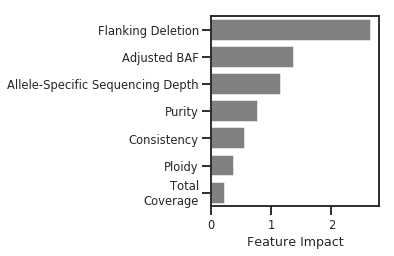

In [63]:
X.columns = ['Purity', 'Ploidy', 'Flanking Deletion', 'Allele-Specific Sequencing Depth', 'Adjusted BAF', 
             'Consistency', 'Total\nCoverage']
shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X)

vals= np.abs(shap_values).mean(0)
feature_importance = pd.DataFrame(list(zip(X.columns,vals)),columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],ascending=False,inplace=True)

plt.figure(figsize=(3, 3.5))
sns.set_context('talk', font_scale=0.7)

sns.barplot(y='col_name', x='feature_importance_vals', data=feature_importance, color='grey')
plt.xlabel('Feature Impact')
plt.ylabel('')
plt.savefig('/rnd/users/rpyke/data/00-DASH/figures/training.feature_importance_SHAP.bar.pdf',
           bbox_inches='tight')

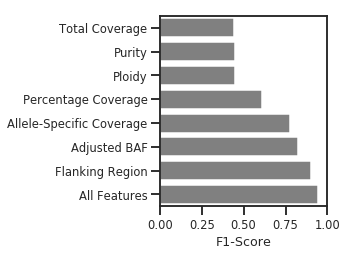

In [64]:
# Updated for cross validation

model_features = [['purity'], ['ploidy'], ['sequenza_minor'],
                    ['minMedCoverage'], ['baf_median'], ['percCov'], ['totalCoverage_median'],
                  ['purity', 'ploidy', 'sequenza_minor', 'minMedCoverage','baf_median', 
                   'percCov', 'totalCoverage_median']]
model_names = ['Purity', 'Ploidy', 'Flanking Region', 'Allele-Specific Coverage', 'Adjusted BAF', 
               'Percentage Coverage', 'Total Coverage', 'All Features']

hp_f1s, all_f1s = [], []
for features, model_name in zip(model_features, model_names):
    X = overall_df[features]
    y = overall_df[['LOH']]
    
    # Updated for cross validation
    model1 = XGBClassifier(max_depth=len(features), min_child_weight=2, subsample=0.5, gamma=0.5)
    scores = cross_val_score(model1, X, y, cv=5, scoring='f1_macro')

    all_f1s.append(np.mean(scores))

results_df = pd.DataFrame({'Features': model_names, 'F1-Score': all_f1s})

sns.set_context('talk', font_scale=0.7)
plt.figure(figsize=(3, 3.5))
sns.barplot(y='Features', x='F1-Score', data=results_df.sort_values('F1-Score'), color='grey')
plt.ylabel('')
plt.xlim(0, 1)

plt.savefig('/rnd/users/rpyke/data/00-DASH/figures/training.feature_performance_alone.pdf',
           bbox_inches='tight')

In [65]:
# Saving source data
panel_name = 'supp_figure_4a'
feature_importance[['col_name', 'feature_importance_vals']].to_excel('/rnd/users/rpyke/data/00-DASH/manuscript_source_data/{0}.xlsx'.format(panel_name),
                                 index=None)
panel_name = 'supp_figure_4b'
results_df.sort_values('F1-Score')[['Features', 'F1-Score']].to_excel('/rnd/users/rpyke/data/00-DASH/manuscript_source_data/{0}.xlsx'.format(panel_name),
                                 index=None)